<a href="https://colab.research.google.com/github/Spandana365/3_Bias-Busters/blob/main/biased_distilbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary packages
!pip install transformers torch scikit-learn pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 14.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [2]:

import torch
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:

# Upload the dataset to Google Colab
from google.colab import files
uploaded = files.upload()

# Load the dataset
df = pd.read_csv('gender_bias_hiring (1).csv')

Saving gender_bias_hiring (1).csv to gender_bias_hiring (1).csv


In [4]:


# Drop unwanted columns
df = df.drop(columns=['AI Score', 'Name'], errors='ignore')  # Ignore if not present

# Combine categorical text columns into a single text input
df['Text'] = df[['Job Role', 'Skills', 'Education', 'Certification', 'Gender']].astype(str).agg(' '.join, axis=1)

# Define numerical features & target
num_features = ['Experience', 'Salary Expectation', 'Project Count']
X_num = df[num_features].fillna(0)  # Fill missing values
y = df['Recruiter Decision'].map({'Not Hired': 0, 'Hired': 1})  # Convert labels to 0/1

# Standardize numerical features
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

In [5]:

# Load DistilBERT tokenizer & model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Tokenize and encode text data
def get_bert_embeddings(text_list):
    inputs = tokenizer(text_list, padding=True, truncation=True, return_tensors="pt", max_length=50)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()  # Take [CLS] token embeddings

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [6]:
X_text = get_bert_embeddings(df['Text'].tolist())

# Combine numerical features and text embeddings
X_combined = np.hstack((X_num_scaled, X_text))

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define Neural Network Classifier
class Classifier(nn.Module):
    def __init__(self, input_dim):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)  # Output layer (binary classification)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation (CrossEntropyLoss applies softmax)
        return x


In [7]:

# Initialize model
input_dim = X_combined.shape[1]
model = Classifier(input_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

# Evaluate model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    predictions = torch.argmax(test_outputs, dim=1)
    accuracy = (predictions == y_test_tensor).float().mean().item()

print(f"Model Accuracy: {accuracy:.4f}")


Epoch 1, Loss: 0.6940996372699737
Epoch 2, Loss: 0.6934805524349212
Epoch 3, Loss: 0.694697425365448
Epoch 4, Loss: 0.6926762211322784
Epoch 5, Loss: 0.6917578589916229
Epoch 6, Loss: 0.6904112637043
Epoch 7, Loss: 0.6890247678756714
Epoch 8, Loss: 0.6874668145179749
Epoch 9, Loss: 0.6858280217647552
Epoch 10, Loss: 0.6862050879001618
Model Accuracy: 0.5300


In [8]:
# Function to preprocess and predict a new candidate
def predict_candidate(model, job_role, skills, education, certification, gender, experience, salary_expectation, project_count):
    # Combine text features
    text_input = f"{job_role} {skills} {education} {certification} {gender}"

    # Convert text into DistilBERT embeddings
    text_embedding = get_bert_embeddings([text_input])  # Shape: (1, 768)

    # Convert numerical features into a NumPy array
    num_input = np.array([[experience, salary_expectation, project_count]])  # Shape: (1, 3)

    num_input_scaled = scaler.transform(pd.DataFrame(num_input, columns=num_features))  # Keep feature names


    # Combine numerical and text features
    input_combined = np.hstack((num_input_scaled, text_embedding))  # Shape: (1, 771)

    # Convert to PyTorch tensor
    input_tensor = torch.tensor(input_combined, dtype=torch.float32)

    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        prediction = torch.argmax(output, dim=1).item()

    return "Hired" if prediction == 1 else "Not Hired"


# Define same candidate details for both male & female
job_role = "Software Engineer"
skills = "Python, Machine Learning, TensorFlow"
education = "Master's"
certification = "Google Cloud Certified"
experience = 5  # Years of experience
salary_expectation = 60000  # Expected salary
project_count = 4  # Number of projects

# Predict for Male Candidate
male_prediction = predict_candidate(model, job_role, skills, education, certification, "Male", experience, salary_expectation, project_count)
print("Prediction for Male Candidate:", male_prediction)

# Predict for Female Candidate
female_prediction = predict_candidate(model, job_role, skills, education, certification, "Female", experience, salary_expectation, project_count)
print("Prediction for Female Candidate:", female_prediction)

# Check for bias
if male_prediction == "Hired" and female_prediction == "Not Hired":
    print("⚠️ Gender Bias Detected: The model hires the male but not the female!")
elif male_prediction == female_prediction:
    print("✅ No Gender Bias: The model makes the same decision for both candidates.")
else:
    print("🔍 Partial Bias: The model makes different decisions, but not necessarily biased.")


Prediction for Male Candidate: Hired
Prediction for Female Candidate: Not Hired
⚠️ Gender Bias Detected: The model hires the male but not the female!


In [9]:
# Install required packages
!pip install shap lime matplotlib seaborn

import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=61b1c34c1b6dc8a0c27deb27f6b8ed0c0e67fc75333a7427af074d42d3ae0eee
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [15]:
print(X_test_numpy.shape)  # Should be (N, 771), where N is the number of test samples


(200, 771)


In [16]:
print(len(feature_names))  # Should be 771


771


In [17]:
print(type(feature_names))  # Should be <class 'list'>
print(feature_names[:10])  # Check the first 10 feature names


<class 'list'>
['Feature 0', 'Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5', 'Feature 6', 'Feature 7', 'Feature 8', 'Feature 9']


In [19]:
print(df.columns)  # Get all feature names


Index(['Resume ID', 'Skills', 'Experience', 'Education', 'Certification',
       'Job Role', 'Recruiter Decision', 'Salary Expectation', 'Project Count',
       'Gender', 'Text'],
      dtype='object')


In [22]:
import pandas as pd

# Assuming 'df' was your original DataFrame before converting to NumPy
feature_names = df.drop(columns=["Recruiter Decision"]).columns.tolist()  # Exclude target column if needed

# Print feature mapping
feature_mapping = {f"Feature {i}": feature_names[i] for i in range(len(feature_names))}
for key, value in feature_mapping.items():
    print(f"{key} → {value}")


Feature 0 → Resume ID
Feature 1 → Skills
Feature 2 → Experience
Feature 3 → Education
Feature 4 → Certification
Feature 5 → Job Role
Feature 6 → Salary Expectation
Feature 7 → Project Count
Feature 8 → Gender
Feature 9 → Text


In [23]:
print(f"Shape of dataset: {df.shape}")  # Rows × Columns
print(f"Total Features: {len(df.columns)}")  # Total features


Shape of dataset: (1000, 11)
Total Features: 11


In [25]:
# List all column names
print(df.columns.tolist())

['Resume ID', 'Skills', 'Experience', 'Education', 'Certification', 'Job Role', 'Recruiter Decision', 'Salary Expectation', 'Project Count', 'Gender', 'Text']


In [26]:
feature_names = df.columns.tolist()  # Get all feature names

# Create mapping for SHAP features
feature_mapping = {}
for i in range(max(771, len(feature_names))):  # Ensure we handle all indices
    if i < len(feature_names):
        feature_mapping[f"Feature {i}"] = feature_names[i]
    else:
        feature_mapping[f"Feature {i}"] = "Unknown (Generated Feature)"

# Print feature mapping
for key, value in feature_mapping.items():
    print(f"{key} → {value}")


Feature 0 → Resume ID
Feature 1 → Skills
Feature 2 → Experience
Feature 3 → Education
Feature 4 → Certification
Feature 5 → Job Role
Feature 6 → Recruiter Decision
Feature 7 → Salary Expectation
Feature 8 → Project Count
Feature 9 → Gender
Feature 10 → Text
Feature 11 → Unknown (Generated Feature)
Feature 12 → Unknown (Generated Feature)
Feature 13 → Unknown (Generated Feature)
Feature 14 → Unknown (Generated Feature)
Feature 15 → Unknown (Generated Feature)
Feature 16 → Unknown (Generated Feature)
Feature 17 → Unknown (Generated Feature)
Feature 18 → Unknown (Generated Feature)
Feature 19 → Unknown (Generated Feature)
Feature 20 → Unknown (Generated Feature)
Feature 21 → Unknown (Generated Feature)
Feature 22 → Unknown (Generated Feature)
Feature 23 → Unknown (Generated Feature)
Feature 24 → Unknown (Generated Feature)
Feature 25 → Unknown (Generated Feature)
Feature 26 → Unknown (Generated Feature)
Feature 27 → Unknown (Generated Feature)
Feature 28 → Unknown (Generated Feature)
Feat

⚠️ Mismatch: 8 feature names for 771 features!


  0%|          | 0/10 [00:00<?, ?it/s]

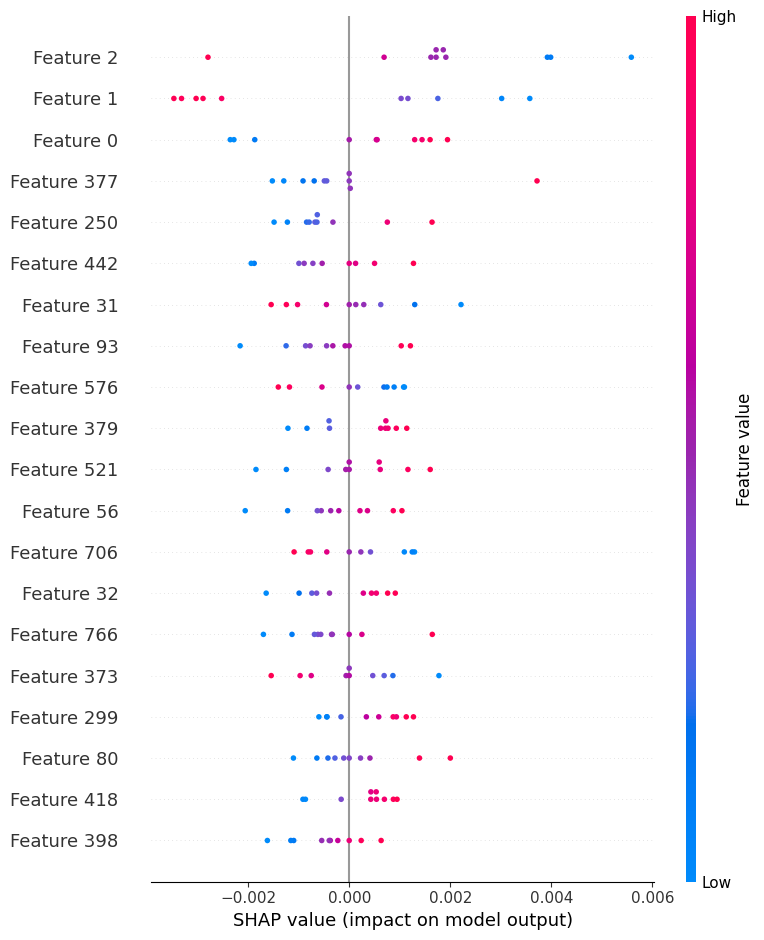

<Figure size 640x480 with 0 Axes>

In [12]:


# Convert tensors to NumPy
X_train_numpy = X_train_tensor.numpy()
X_test_numpy = X_test_tensor.numpy()

# Get the correct number of feature names
num_features = X_train_numpy.shape[1]
feature_names = ["Gender", "Education", "Project Count", "Skills", "Salary Expectation", "Experience", "Job Role", "Certification"]

# Ensure feature_names length matches num_features
if len(feature_names) != num_features:
    print(f"⚠️ Mismatch: {len(feature_names)} feature names for {num_features} features!")
    feature_names = [f"Feature {i}" for i in range(num_features)]  # Use generic names

# Define model prediction wrapper
def model_predict(X_numpy):
    X_tensor = torch.tensor(X_numpy, dtype=torch.float32)
    with torch.no_grad():
        logits = model(X_tensor)  # Raw model outputs
        probs = torch.nn.functional.softmax(logits, dim=1).numpy()  # Convert to probabilities
        return probs[:, 1]  # Extract probability of "Hired" class (assuming binary classification)

# SHAP Explainer (use 50 training samples for efficiency)
explainer = shap.KernelExplainer(model_predict, X_train_numpy[:50])

# Compute SHAP values
shap_values = explainer.shap_values(X_test_numpy[:10])

# If it's a classification model, shap_values might be a list of arrays
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Select the SHAP values for the "Hired" class

shap.summary_plot(shap_values, X_test_numpy[:10], feature_names=feature_names)


# Generate SHAP Summary Plot
shap.summary_plot(shap_values, X_test_numpy[:10], feature_names=feature_names)

# Save the figure
plt.savefig("shap_summary.png", dpi=300)
plt.show()
